In [59]:
import pandas as pd
import ast
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
import time

In [60]:
# Cell 2: Load and preprocess data
# Define essential columns
essential_columns = [
    'customer_id', 'timestamp', 'merchant_category', 'amount', 'country',
    'city_size', 'card_type', 'card_present', 'device', 'channel',
    'distance_from_home', 'high_risk_merchant', 'transaction_hour',
    'weekend_transaction', 'velocity_last_hour', 'is_fraud'
]

In [61]:
# Load data
# Load data from zip file
def load_from_zip(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open('synthetic_fraud_data.csv') as file:
            df = pd.read_csv(file, usecols=essential_columns)
    return df

df = load_from_zip('/Users/dhyeydesai/Desktop/FRAUD_DATA/synthetic_fraud_data.csv.zip')

In [62]:
df.head(10)

,customer_id,timestamp,merchant_category,amount,country,city_size,card_type,card_present,device,channel,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction,velocity_last_hour,is_fraud
0,CUST_72886,2024-09-30 00:00:01.034820+00:00,Restaurant,294.87,UK,medium,Platinum Credit,False,iOS App,mobile,0,False,0,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,CUST_70474,2024-09-30 00:00:01.764464+00:00,Entertainment,3368.97,Brazil,medium,Platinum Credit,False,Edge,web,1,True,0,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,CUST_10715,2024-09-30 00:00:02.273762+00:00,Grocery,102582.38,Japan,medium,Platinum Credit,False,Firefox,web,0,False,0,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,CUST_16193,2024-09-30 00:00:02.297466+00:00,Gas,630.60,Australia,medium,Premium Debit,False,iOS App,mobile,0,False,0,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,CUST_87572,2024-09-30 00:00:02.544063+00:00,Healthcare,724949.27,Nigeria,medium,Basic Debit,False,Chrome,web,1,False,0,False,"{'num_transactions': 218, 'total_amount': 4827...",True
5,CUST_55630,2024-09-30 00:00:03.050458+00:00,Education,11.76,Brazil,medium,Platinum Credit,False,Chrome,web,1,False,0,False,"{'num_transactions': 1130, 'total_amount': 695...",True
6,CUST_89147,2024-09-30 00:00:03.149440+00:00,Grocery,2606.19,Brazil,medium,Platinum Credit,False,Android App,mobile,0,False,0,False,"{'num_transactions': 1392, 'total_amount': 607...",False
7,CUST_10150,2024-09-30 00:00:06.295911+00:00,Travel,828.33,Germany,medium,Platinum Credit,False,Edge,web,0,True,0,False,"{'num_transactions': 352, 'total_amount': 8690...",False
8,CUST_83143,2024-09-30 00:00:06.813965+00:00,Healthcare,104921.00,Nigeria,medium,Premium Debit,False,Edge,web,0,False,0,False,"{'num_transactions': 618, 'total_amount': 7840...",False
9,CUST_35022,2024-09-30 00:00:07.105592+00:00,Retail,51521.84,Mexico,medium,Premium Debit,True,NFC Payment,pos,1,False,0,False,"{'num_transactions': 723, 'total_amount': 1446...",True


In [63]:
# Convert timestamp and handle categorical data
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', errors='coerce')
for col in ['merchant_category', 'country', 'city_size', 'card_type', 'device', 'channel']:
    df[col] = df[col].astype('category')

In [64]:
# Handle velocity_last_hour
df['velocity_last_hour'] = df['velocity_last_hour'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
velocity_df = df['velocity_last_hour'].apply(pd.Series)
print("Velocity features created:")
print(velocity_df.columns)

Velocity features created:
Index(['num_transactions', 'total_amount', 'unique_merchants',
       'unique_countries', 'max_single_amount'],
      dtype='object')


In [65]:
# Drop unnecessary columns
df.drop(columns=['timestamp', 'customer_id'], inplace=True)

In [66]:
boolean_columns = df.select_dtypes(include=['bool']).columns
print("Boolean columns found:", boolean_columns.tolist())

# Convert boolean columns to int
for col in boolean_columns:
    df[col] = df[col].astype(int)

# Binary encoding
binary_cols = ['card_present', 'high_risk_merchant', 'weekend_transaction', 'is_fraud']
for col in binary_cols:
    df[col] = df[col].map({
        1: 1, 'yes': 1, 'Yes': 1, 'True': 1, True: 1,
        0: 0, 'no': 0, 'No': 0, 'False': 0, False: 0
    }).astype(int)

# Verify binary columns
print("\nVerifying binary columns:")
for col in binary_cols:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())
    print(f"Unique values: {sorted(df[col].unique())}")


Boolean columns found: ['card_present', 'high_risk_merchant', 'weekend_transaction', 'is_fraud']

Verifying binary columns:

card_present value counts:
card_present
0    6832719
1     651047
Name: count, dtype: int64
Unique values: [0, 1]

high_risk_merchant value counts:
high_risk_merchant
0    5611803
1    1871963
Name: count, dtype: int64
Unique values: [0, 1]

weekend_transaction value counts:
weekend_transaction
0    5554103
1    1929663
Name: count, dtype: int64
Unique values: [0, 1]

is_fraud value counts:
is_fraud
0    5989047
1    1494719
Name: count, dtype: int64
Unique values: [0, 1]


In [67]:
le = LabelEncoder()
for col in ['city_size', 'channel']:
    df[col] = le.fit_transform(df[col])
    print(f"\nUnique values in {col} after encoding:")
    print(df[col].value_counts())

# One-hot encoding for nominal columns
nominal_cols = ['merchant_category', 'country', 'card_type', 'device']
df = pd.get_dummies(
    df,
    columns=nominal_cols,
    drop_first=True
)

print("\nNew columns created after one-hot encoding:")
print([col for col in df.columns if any(x in col for x in nominal_cols)])


Unique values in city_size after encoding:
city_size
1    7284598
0     199168
Name: count, dtype: int64

Unique values in channel after encoding:
channel
2    4563141
0    2269578
1     651047
Name: count, dtype: int64

New columns created after one-hot encoding:
['merchant_category_Entertainment', 'merchant_category_Gas', 'merchant_category_Grocery', 'merchant_category_Healthcare', 'merchant_category_Restaurant', 'merchant_category_Retail', 'merchant_category_Travel', 'country_Brazil', 'country_Canada', 'country_France', 'country_Germany', 'country_Japan', 'country_Mexico', 'country_Nigeria', 'country_Russia', 'country_Singapore', 'country_UK', 'country_USA', 'card_type_Basic Debit', 'card_type_Gold Credit', 'card_type_Platinum Credit', 'card_type_Premium Debit', 'device_Chip Reader', 'device_Chrome', 'device_Edge', 'device_Firefox', 'device_Magnetic Stripe', 'device_NFC Payment', 'device_Safari', 'device_iOS App']


In [68]:
# Combine with velocity features
df = pd.concat([df, velocity_df], axis=1)

In [69]:
# Check final data quality
print("\nFinal data info:")
print(df.info())


Final data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 45 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   amount                           float64
 1   city_size                        int64  
 2   card_present                     int64  
 3   channel                          int64  
 4   distance_from_home               int64  
 5   high_risk_merchant               int64  
 6   transaction_hour                 int64  
 7   weekend_transaction              int64  
 8   velocity_last_hour               object 
 9   is_fraud                         int64  
 10  merchant_category_Entertainment  bool   
 11  merchant_category_Gas            bool   
 12  merchant_category_Grocery        bool   
 13  merchant_category_Healthcare     bool   
 14  merchant_category_Restaurant     bool   
 15  merchant_category_Retail         bool   
 16  merchant_category_Travel         boo

In [70]:
# Check for any remaining boolean or object columns
remaining_bool = df.select_dtypes(include=['bool']).columns
remaining_object = df.select_dtypes(include=['object']).columns

print("\nRemaining boolean columns:", remaining_bool.tolist())
print("Remaining object columns:", remaining_object.tolist())


Remaining boolean columns: ['merchant_category_Entertainment', 'merchant_category_Gas', 'merchant_category_Grocery', 'merchant_category_Healthcare', 'merchant_category_Restaurant', 'merchant_category_Retail', 'merchant_category_Travel', 'country_Brazil', 'country_Canada', 'country_France', 'country_Germany', 'country_Japan', 'country_Mexico', 'country_Nigeria', 'country_Russia', 'country_Singapore', 'country_UK', 'country_USA', 'card_type_Basic Debit', 'card_type_Gold Credit', 'card_type_Platinum Credit', 'card_type_Premium Debit', 'device_Chip Reader', 'device_Chrome', 'device_Edge', 'device_Firefox', 'device_Magnetic Stripe', 'device_NFC Payment', 'device_Safari', 'device_iOS App']
Remaining object columns: ['velocity_last_hour']


In [71]:
null_counts = df.isnull().sum()
if null_counts.any():
    print("\nColumns with null values:")
    print(null_counts[null_counts > 0])
else:
    print("\nNo null values found in the dataset")


No null values found in the dataset


In [72]:
# Display final shape and sample
print("\nFinal data shape:", df.shape)
print("\nSample of processed data:")
display(df.head())


Final data shape: (7483766, 45)

Sample of processed data:


,amount,city_size,card_present,channel,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction,velocity_last_hour,is_fraud,...,device_Firefox,device_Magnetic Stripe,device_NFC Payment,device_Safari,device_iOS App,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount
0,294.87,1,0,0,0,0,0,0,"{'num_transactions': 1197, 'total_amount': 334...",0,...,False,False,False,False,True,1197.0,3.349856e+07,105.0,12.0,1.925481e+06
1,3368.97,1,0,2,1,1,0,0,"{'num_transactions': 509, 'total_amount': 2011...",1,...,False,False,False,False,False,509.0,2.011476e+07,100.0,12.0,5.149117e+06
2,102582.38,1,0,2,0,0,0,0,"{'num_transactions': 332, 'total_amount': 3916...",0,...,True,False,False,False,False,332.0,3.916385e+07,97.0,12.0,1.852242e+06
3,630.60,1,0,0,0,0,0,0,"{'num_transactions': 764, 'total_amount': 2201...",0,...,False,False,False,False,True,764.0,2.201260e+07,105.0,12.0,2.055798e+06
4,724949.27,1,0,2,1,0,0,0,"{'num_transactions': 218, 'total_amount': 4827...",1,...,False,False,False,False,False,218.0,4.827636e+06,88.0,12.0,1.157231e+06


In [73]:
# Drop unnecessary columns
df.drop(columns=['velocity_last_hour'], inplace=True)

In [74]:
# Display final shape and sample
print("\nFinal data shape:", df.shape)
print("\nSample of processed data:")
display(df.head())


Final data shape: (7483766, 44)

Sample of processed data:


,amount,city_size,card_present,channel,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction,is_fraud,merchant_category_Entertainment,...,device_Firefox,device_Magnetic Stripe,device_NFC Payment,device_Safari,device_iOS App,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount
0,294.87,1,0,0,0,0,0,0,0,False,...,False,False,False,False,True,1197.0,3.349856e+07,105.0,12.0,1.925481e+06
1,3368.97,1,0,2,1,1,0,0,1,True,...,False,False,False,False,False,509.0,2.011476e+07,100.0,12.0,5.149117e+06
2,102582.38,1,0,2,0,0,0,0,0,False,...,True,False,False,False,False,332.0,3.916385e+07,97.0,12.0,1.852242e+06
3,630.60,1,0,0,0,0,0,0,0,False,...,False,False,False,False,True,764.0,2.201260e+07,105.0,12.0,2.055798e+06
4,724949.27,1,0,2,1,0,0,0,1,False,...,False,False,False,False,False,218.0,4.827636e+06,88.0,12.0,1.157231e+06


In [75]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

In [76]:
# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Second split: separate train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_temp
)

print("Data split sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Data split sizes:
Training set: (4490259, 43)
Validation set: (1496753, 43)
Test set: (1496754, 43)


In [77]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [78]:
# Convert to DataFrames with column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [79]:
# Ridge Regression for feature importance
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled_df, y_train)
ridge_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(ridge.coef_)
}).sort_values('importance', ascending=False)

# Lasso Regression for feature selection
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled_df, y_train)
lasso_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(lasso.coef_)
}).sort_values('importance', ascending=False)


In [80]:
# Select features based on Lasso
selected_features = lasso_importance[lasso_importance['importance'] > 0]['feature'].tolist()


In [81]:
# Apply feature selection
X_train_selected = X_train_scaled_df[selected_features]
X_val_selected = X_val_scaled_df[selected_features]
X_test_selected = X_test_scaled_df[selected_features]

print(f"Selected {len(selected_features)} features")
print("\nTop 10 most important features:")
display(ridge_importance.head(10))

Selected 8 features

Top 10 most important features:


,feature,importance
4,distance_from_home,0.165879
2,card_present,0.078876
6,transaction_hour,0.047368
15,country_Brazil,0.044248
35,device_NFC Payment,0.044203
34,device_Magnetic Stripe,0.044200
30,device_Chip Reader,0.044079
20,country_Mexico,0.043862
22,country_Russia,0.042088
21,country_Nigeria,0.031004


In [82]:
X_train_selected = X_train_selected.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [83]:
# Combine features and target
train_data = pd.concat([X_train_selected, pd.Series(y_train, name='target')], axis=1)

In [84]:
# Separate majority and minority classes
train_majority = train_data[train_data['target'] == 0]
train_minority = train_data[train_data['target'] == 1]

In [85]:
# Upsample minority class
train_minority_upsampled = resample(
    train_minority,
    replace=True,
    n_samples=len(train_majority),
    random_state=42
)

In [86]:
# Combine majority and upsampled minority
train_balanced = pd.concat([train_majority, train_minority_upsampled])
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [87]:
# Separate features and target
X_train_balanced = train_balanced.drop('target', axis=1)
y_train_balanced = train_balanced['target']

print("Class distribution after balancing:")
print(y_train_balanced.value_counts(normalize=True))

Class distribution after balancing:
target
0    0.5
1    0.5
Name: proportion, dtype: float64


In [88]:
def train_and_evaluate_model(model, model_name, X_train, X_val, X_test, y_train, y_val, y_test):
    # Train model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Make predictions
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
    
    # Calculate metrics
    results = {
        'model_name': model_name,
        'training_time': training_time,
        'validation_accuracy': accuracy_score(y_val, val_pred),
        'test_accuracy': accuracy_score(y_test, test_pred),
        'validation_roc_auc': roc_auc_score(y_val, val_pred),
        'test_roc_auc': roc_auc_score(y_test, test_pred),
        'validation_report': classification_report(y_val, val_pred),
        'test_report': classification_report(y_test, test_pred),
        'validation_confusion_matrix': confusion_matrix(y_val, val_pred),
        'test_confusion_matrix': confusion_matrix(y_test, test_pred)
    }
    
    return results

In [89]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(),
    'LightGBM': LGBMClassifier()
}

In [90]:
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    results[name] = train_and_evaluate_model(
        model, name,
        X_train_balanced, X_val_selected, X_test_selected,
        y_train_balanced, y_val, y_test
    )
    
    print(f"Training Time: {results[name]['training_time']:.2f} seconds")
    print(f"Validation Accuracy: {results[name]['validation_accuracy']:.4f}")
    print(f"Test Accuracy: {results[name]['test_accuracy']:.4f}")
    print(f"Validation ROC AUC: {results[name]['validation_roc_auc']:.4f}")
    print(f"Test ROC AUC: {results[name]['test_roc_auc']:.4f}")


Training Logistic Regression...
Training Time: 5.56 seconds
Validation Accuracy: 0.9069
Test Accuracy: 0.9074
Validation ROC AUC: 0.9096
Test ROC AUC: 0.9102

Training Random Forest...
Training Time: 1030.73 seconds
Validation Accuracy: 0.9411
Test Accuracy: 0.9413
Validation ROC AUC: 0.9085
Test ROC AUC: 0.9089

Training Gradient Boosting...
Training Time: 617.96 seconds
Validation Accuracy: 0.9334
Test Accuracy: 0.9337
Validation ROC AUC: 0.9314
Test ROC AUC: 0.9316

Training LightGBM...
[LightGBM] [Info] Number of positive: 3593428, number of negative: 3593428
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 7186856, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0000

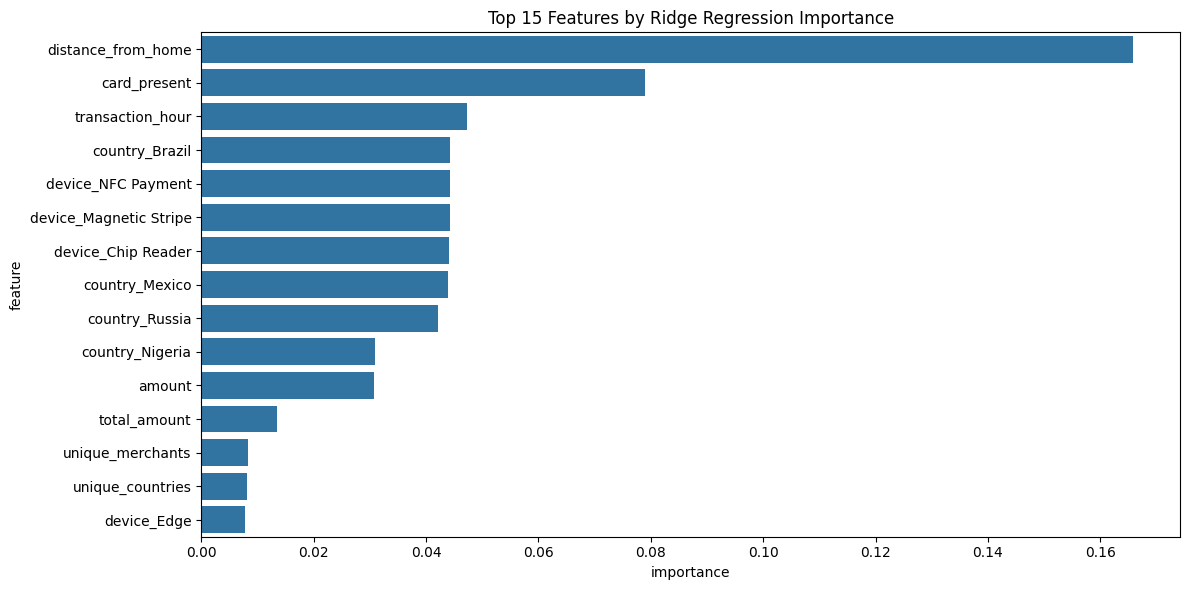

In [93]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=ridge_importance.head(15),
    x='importance',
    y='feature'
)
plt.title('Top 15 Features by Ridge Regression Importance')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

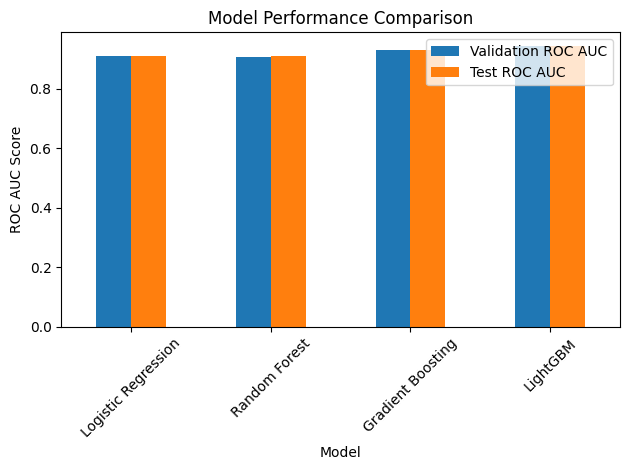

In [94]:
# Plot model performance comparison
model_metrics = pd.DataFrame({
    'Model': list(results.keys()),
    'Validation Accuracy': [results[model]['validation_accuracy'] for model in results],
    'Test Accuracy': [results[model]['test_accuracy'] for model in results],
    'Validation ROC AUC': [results[model]['validation_roc_auc'] for model in results],
    'Test ROC AUC': [results[model]['test_roc_auc'] for model in results]
})

plt.figure(figsize=(12, 6))
model_metrics.set_index('Model')[['Validation ROC AUC', 'Test ROC AUC']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('ROC AUC Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()